In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Loading and preprocessing Image Dataset

In [2]:

import torch.utils.data.dataloader
# resizing image to 224x224 and converting to tensors
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(), 
transforms.Normalize((0.5,), (0.5,))])
# Loading dataset
train_dt = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_ld = torch.utils.data.DataLoader(train_dt, batch_size = 32, shuffle = True)

test_dt = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_ld = torch.utils.data.DataLoader(test_dt, batch_size = 32, shuffle = False)

class_names = train_dt.classes

print("Data Loaded Successfully")

Data Loaded Successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


torch.Size([3, 224, 224]) tensor(8)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

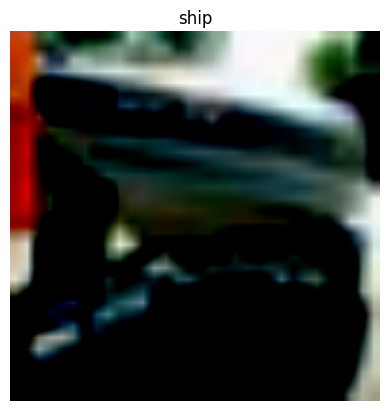

In [3]:

image_batch, label_batch = next(iter(train_ld))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

Patch Embedding Layer

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.num_patches = (img_size // patch_size) **2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride= patch_size)

    def forward (self, x):
        x= self.projection(x)
        x= x.flatten(2)
        x= x.transpose(1, 2)
        return x


Adding Class Token & Positional Encoding

In [5]:
class ViTEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size,patch_size,in_channels,embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x= self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x= torch.cat((cls_tokens, x), dim=1)
        x= x+self.pos_embedding
        return x
   


Multi-Head Self-Attention (MHSA)

In [6]:
class MHSA(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 12, attn_dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim= embed_dim, num_heads = num_heads, dropout= attn_dropout,batch_first=True)

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)
        return attn_output

MLP Block

In [7]:
class MLP(nn.Module):
    def __init__(self, embed_dim = 768, mlp_size = 3072, dropout = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embed_dim, out_features= mlp_size), nn.GELU(), nn.Dropout(p=dropout), 
                                 nn.Linear(in_features=mlp_size, out_features=embed_dim),nn.Dropout(p=dropout))
        

    def forward(self, x):
        x= self.layer_norm(x)
        x= self.mlp(x)
        return x


Creating a Transformer Encoder by Combining custom made layer

In [8]:
class transformerEncoder(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 12, mlp_size = 3072, attn_dropout = 0, mlp_dropout = 0.1):
        super().__init__()
        self.msa_block = MHSA(embed_dim=embed_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLP(embed_dim=embed_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x


In [9]:
transfomer_encoder_block = transformerEncoder()
from torchinfo import summary

summary(model=transfomer_encoder_block, input_size=(1, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings= ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
transformerEncoder (transformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MHSA (msa_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Building a Vision Transformer

In [10]:
class ViT(nn.Module):
    def __init__(self,img_size = 224,patch_size = 16, in_channels = 3, embed_dim = 768,num_transformer_layer = 12,num_heads = 12, mlp_size = 3072, attn_dropout = 0, mlp_dropout = 0.1,embedding_dropout = 0.1,num_classes = 10):
        super().__init__()

      #  assert img_size % patch_size == 0, f"Image must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

      #  self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.embedding = ViTEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.transformer_encoder = nn.Sequential(*[transformerEncoder(embed_dim=embed_dim,num_heads=num_heads,mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])

        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return self.mlp_head(x[:, 0])    

Training Model

In [11]:
import torch 
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.3)

def train_model(model, train_ld, num_epochs = 10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_ld:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Compoleted")

train_model(model, train_ld)

Epoch 1 Compoleted
Epoch 2 Compoleted
Epoch 3 Compoleted
Epoch 4 Compoleted
Epoch 5 Compoleted
Epoch 6 Compoleted
Epoch 7 Compoleted
Epoch 8 Compoleted
Epoch 9 Compoleted
Epoch 10 Compoleted


In [16]:
import torch

model.eval()  # Set the model to evaluation mode
train_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_ld:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_loss /= len(train_ld)
train_accuracy = 100 * correct / total

print(f"Final Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")


Final Train Loss: 2.0377, Train Accuracy: 22.80%


In [17]:
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_ld:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss /= len(test_ld)
val_accuracy = 100 * correct / total

print(f"Final Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Final Validation Loss: 2.0310, Validation Accuracy: 22.26%


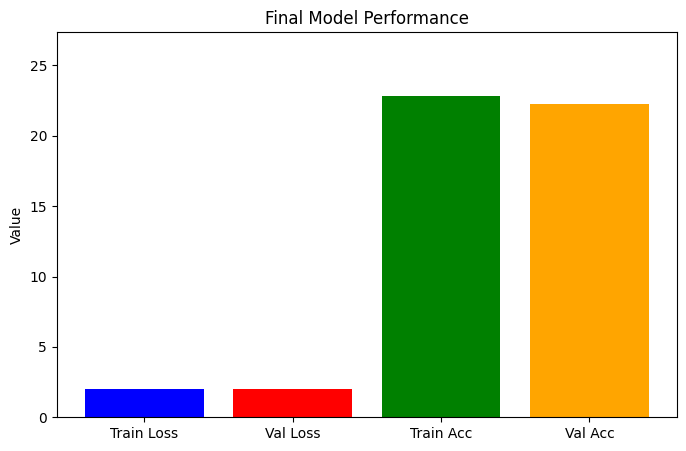

In [24]:
import matplotlib.pyplot as plt

# Create bar plots for final accuracy and loss
metrics = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
values = [train_loss, val_loss, train_accuracy, val_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'red', 'green', 'orange'])
plt.title("Final Model Performance")
plt.ylabel("Value")
plt.ylim(0, max(values) * 1.2)
plt.show()



Training the same Dataset with pre-trained model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt


In [13]:
# Data Transformations: Normalization and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Pre-trained model normalization
])

# Load the CIFAR-10 training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
# Load the pre-trained ViT model
model = models.vit_b_16(pretrained=True)

pretrained_vit = torchvision.models.vit_b_16(weights= model)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Replace the final classifier to match CIFAR-10 (10 classes)
pretrained_vit.heads = nn.Linear(in_features = 768, out_features=10)



/home/sameer-malik/Torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameer-malik/Torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
from torchinfo import summary

summary(model = pretrained_vit, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings= ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=1e-3)

In [ ]:
# Function to train the model
def train_model(pretrained_vit, train_loader, criterion, optimizer, num_epochs=10):
    pretrained_vit.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 9.0467, Accuracy: 0.00%
Epoch 2/10, Loss: 9.0467, Accuracy: 0.00%
